# Introduction

This notebook shows some examples concerning data analysis, e.g. fitting data, examining correlations, and applying external (_systematic_) measurements.    I am generally a fan of using python packages for analysis, including numpy, scipy, and matplotlib.  However, to perform more powerful analyses, I still find the staple of the physics community community, `ROOT`, to be a very important tool.  

The analysis in this example itself depends on `ROOT`, and also assumes that the associated `pyROOT` is correctly installed.  If you wish to run this examples yourself, please install [ROOT](http://root.cern.ch) and make sure the [pyROOT](https://root.cern.ch/drupal/content/pyroot) is also installed.

This example also makes significant use of [RooFit](https://root.cern.ch/drupal/content/roofit), which is a library for doing simple to complicated analyses (e.g. with likelihood and $\chi^2$ fitting) with ROOT.

### Overview

The first part of this example focuses on the very simple fitting of a histogram of counts using a gaussian function.  The second part looks at a 'real-case' scenario, or the fitting of a curve using the $\chi^2$ method.  Finally, we also demonstrate how external measurements may be applied directly to a fit.  

This is not meant as a comprehensive guide, but as an introduction to some basic issues in fitting.

## Boilerplate

Defining some function, imports.

In [1]:
# Make sure matplotlib plots are inline
%matplotlib inline
# grab the ROOT package.
import ROOT

In [2]:
# So we can show ROOT plots inline
import os

if not os.path.exists("rootnotes.py"):
    # Download if it's not here.
    import urllib
    testfile = urllib.URLopener()
    testfile.retrieve("https://gist.githubusercontent.com/mazurov/6194738/raw/67e851fdac969e670a11296642478f1801324b8d/rootnotes.py", 
                      "rootnotes.py")

# Now import the file
import rootnotes
c1 = rootnotes.canvas()

# Overload RooPrintable output
astr = ROOT.ostringstream()
ROOT.RooPrintable.defaultPrintStream(astr)
def print_roofit(obj, *args):
    astr.str("")    
    obj.Print(*args)
    print(astr.str())

TStreamerInfo::Build::0: RuntimeWarning: basic_ios<char,char_traits<char> >: base class ios_base has no streamer or dictionary it will not be saved
TStreamerInfo::Build::0: RuntimeWarning: basic_ostream<char,char_traits<char> >: base class basic_ios<char,char_traits<char> > has no streamer or dictionary it will not be saved


In [3]:
"""
Function to plot the correlation given RooFitResult and two variables.
"""
def plot_correlation(fit_res, var_one, var_two):
    corr_hist = fit_res.correlationHist()

    mn_mean, err_mean = var_one.getVal(), 2*var_one.getError()
    mn_sig, err_sig = var_two.getVal(), 2*var_two.getError()
    fr_corr = RooPlot(var_one, var_two, 
                      mn_mean - err_mean,
                      mn_mean + err_mean,
                      mn_sig - err_sig,
                      mn_sig + err_sig
                     )
    fit_res.plotOn( fr_corr, var_one, var_two, "ME12ABHV")
    fr_corr.Draw()

## Measuring neutrons example

This is just a simple example showing the fitting of a histogram using a gaussian function.  We also look at the correlation between parameters.

In [4]:
from ROOT import ( 
                   RooGaussian,
                   RooRealVar,
                   RooArgSet,
                   RooExtendPdf,
                   RooPlot,
                 )
# Let's consider first the measurement and fitting of a particular variable.
# Say, we have a measurement of neutrons counts.  We can fit these with a
# gaussian

sigma = RooRealVar("sigma", "sigma", 10, 0, 20)
mean = RooRealVar("mean", "mean", 1000, 900, 1100)
counts = RooRealVar("counts", "counts", 900, 1100)
num_neutrons = RooRealVar("total_neutrons", "total_neutrons", 10000, 0, 1000000)

gauss = RooGaussian("gauss", "gauss", counts, mean, sigma) 
ext_gauss = RooExtendPdf("gauss_ext", "gauss_ext", gauss, num_neutrons)


In [5]:
# Simulate data
data = ext_gauss.generate(RooArgSet(counts), ROOT.RooFit.Extended())

# Fit the data
res = ext_gauss.fitTo(data, ROOT.RooFit.Save())

# print from fit result
print_roofit(res)


  RooFitResult: minimized FCN value: -44911.5, estimated distance to minimum: 1.27119e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MIGRAD=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                  mean    9.9991e+02 +/-  9.97e-02
                 sigma    9.9715e+00 +/-  7.05e-02
        total_neutrons    9.9990e+03 +/-  1.00e+02




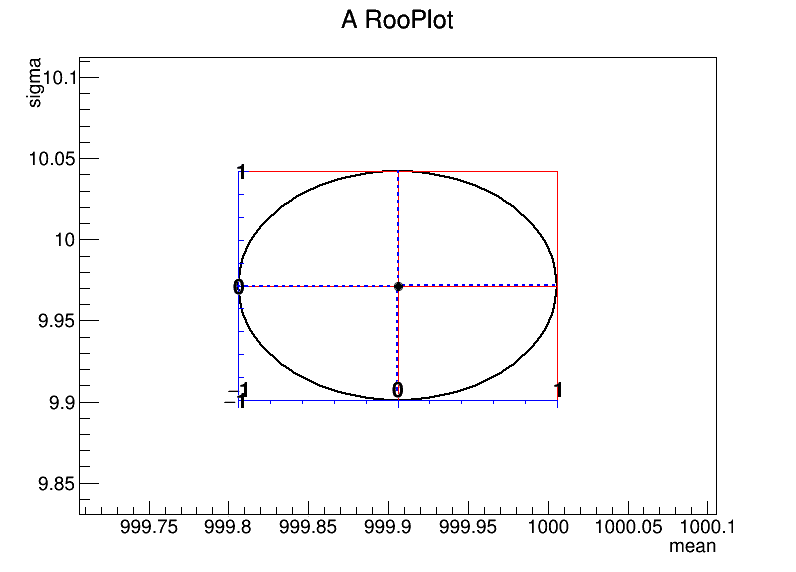

In [6]:
# Plot the correlation histogram.  This will be circular because there is very little correlation between parameters.

plot_correlation(res, mean, sigma)
# Output histogram
c1

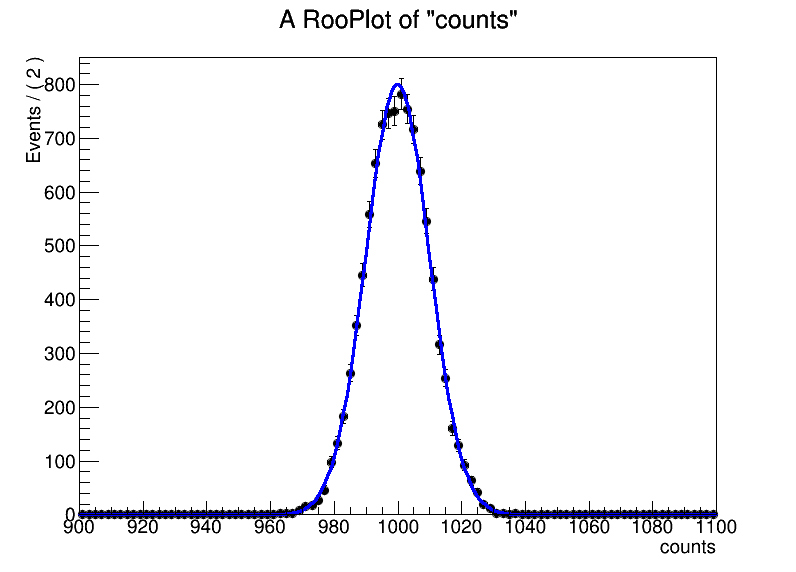

In [7]:
# Plot the best fit and the data.
pl = counts.frame()
data.plotOn(pl)
ext_gauss.plotOn(pl)
pl.Draw()
c1

## Now for something a bit different

Let's consider the case where we've performed two measurements and wish to combine the results in order to propagate the errors from one.  In this case we have:

1. Measured the calibration of a digitizer card, so that we have the function ADC -> Magnetic Field (and associated error)
1. Measured the free induction decay of some polarized species.

First, our calibration data, we'll assume we have a simple scaling calibration:

In [8]:
muT_per_ADC = 4.0 # Arbitrary muT / ADC counts
muT_per_ADC_err = 0.2 # an error in muT / ADC counts

### Create the simulated 'data'
#### Function

The function for an ideal free induction decay should look like:

$$
  a + b e^{-t/\gamma} \sin \left( 2 \pi \omega t + \phi \right) 
$$

where $a$ is the offset, $b$ is the initial amplitude, $\gamma$ is the decay constant, $\omega$ is the oscillation frequency, $b$ is the oscillation amplitude, and $\phi$ is the initial phase. 

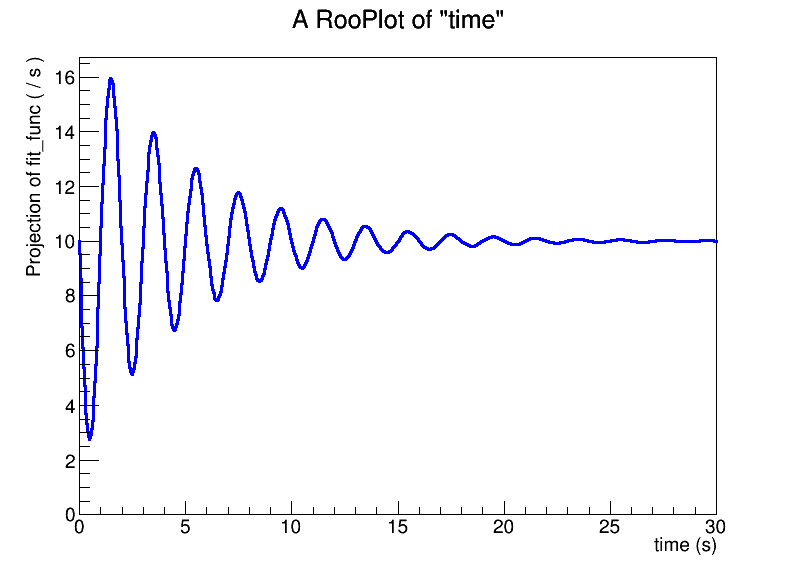

In [9]:
#import a few more variables
from ROOT import (
    RooFormulaVar,
    RooArgList
)

offset = RooRealVar("offset", "a", 10, 0, 100)
decay_time = RooRealVar("decay_const", "#gamma", 5, 0, 1000)
osc_freq = RooRealVar("osc_freq", "#omega", 0.5, 0, 3)
osc_phase = RooRealVar("osc_phase", "#phi", 0, ROOT.TMath.TwoPi())
osc_amp = RooRealVar("osc_amp", "b", 8, 0, 30)
time_var = RooRealVar("time", "time", 0, 30, "s")

exp_func = RooFormulaVar("exp_func", "exp_func", "exp(-@0/@1)", 
                         RooArgList(time_var, decay_time))
sin_func = RooFormulaVar("sin_func", "sin_func", "sin(@0*@1*{} + @2)".format(ROOT.TMath.TwoPi()), 
                         RooArgList(time_var, osc_freq, osc_phase))
fit_func = RooFormulaVar("fit_func", "fit_func", "@0 + @1*@2*@3", 
                         RooArgList(offset, osc_amp, sin_func, exp_func))

ap = time_var.frame()
fit_func.plotOn(ap)
ap.Draw()
c1

#### Simulated data from function

Here we create 'toy' data by assuming some sort of noise on the ADC with a given amplitude.  That is, we use the mean value of the fit function at a given time and then add a random (gaussian-distributed) number with a given noise amplitude.

In [10]:
from ROOT import (
    TRandom3,
    RooDataSet,
    RooMinuit,
    RooXYChi2Var
    )

noise_amplitude = 0.3
time_delta = 0.1
# build data set


adc_counts = RooRealVar("adc", "adc", 0, 30)


# Random number generator (Mersenne-Twister), seeded with the time
rand = TRandom3(0)

# RooFit uses the weight variables in RooDataSet to be able to perform chi-square fits
ts = RooArgSet(time_var, adc_counts)
ds = RooDataSet("sim_data", "sim_data", ts, ROOT.RooFit.WeightVar(adc_counts))

# Now build the data set
cur_time = 0
while cur_time < 30:
    time_var.setVal(cur_time)
    adc_cts = fit_func.getVal() + noise_amplitude*rand.Gaus()
    ds.add(RooArgSet(time_var), adc_cts, noise_amplitude)
    cur_time += time_delta
    
print_roofit(ds, "tv")


DataStore sim_data (sim_data)
  Contains 300 entries
  Observables: 
    1)  time = 29.9  L(0 - 30) // [s] "time"
  Dataset variable "adc" is interpreted as the event weight



#### Building the $\chi^2$ function

In principle, we could use maximum likelihood to fit this, but we are already assuming the error bars on all the points are gaussian.  (We constructed them to be!)  In general, for data coming e.g. from a digitizer or measurement device, this is usually a decent assumption.


  RooFitResult: minimized FCN value: 300.786, estimated distance to minimum: 9.83245e-09
                covariance matrix quality: Full, accurate covariance matrix
                Status : MIGRAD=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
           decay_const    4.9442e+00 +/-  1.05e-01
                offset    9.9975e+00 +/-  1.74e-02
               osc_amp    8.0267e+00 +/-  1.22e-01
              osc_freq    4.9941e-01 +/-  6.78e-04
             osc_phase    3.1612e+00 +/-  1.46e-02




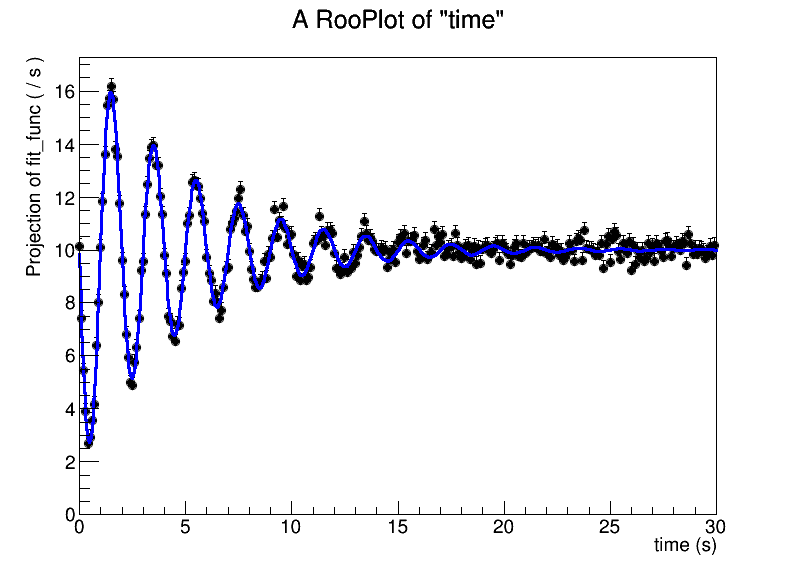

In [11]:
# Build the chi-square function
chi_sq = RooXYChi2Var("chi_sq", "chi_sq", fit_func, ds)

# Minuit is *the* tool for minimization of functions.  Here we pass it the function to be minimized
minuit = RooMinuit(chi_sq)

# Migrad is generally the most robust tool to use for minimization.
minuit.migrad()

# Print out the results of the fit
fit_res = minuit.save()
print_roofit(fit_res)

# Plot everything
apt = time_var.frame()
ds.plotOnXY(apt)
fit_func.plotOn(apt)
apt.Draw()
c1

#### Looking at the correlations in the fit.
Now, we can output the correlation between $b$ and $\gamma$ (amplitude and decay constant).  We definitely see a correlation!

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: correlation_matrix (Potential memory leak).


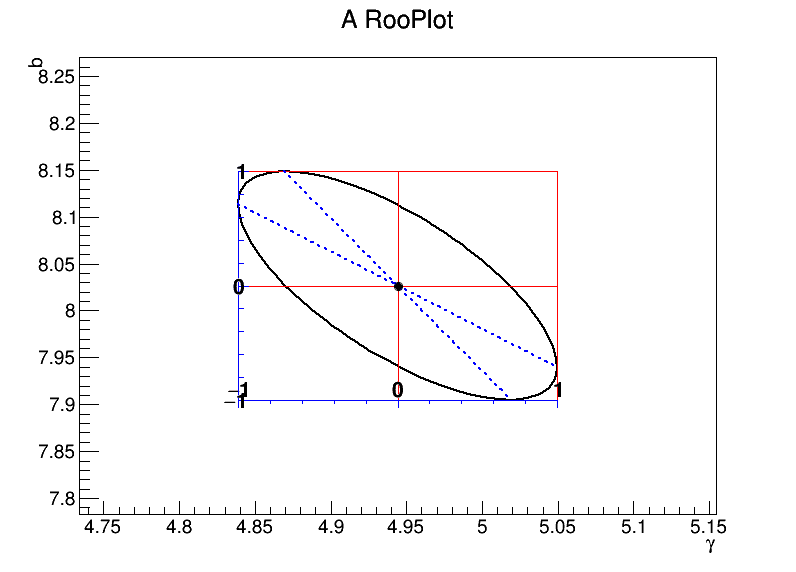

In [12]:
plot_correlation(fit_res, decay_time, osc_amp)
c1

Now, let's combine the calibration data with this fit.  In other words, we would like to get the amplitude and offset in terms of $\mu$T instead of ADC counts.  In principle, we can also combine this _by hand_, but this shows how one would do it during the fit.

The first thing to realize is that, whereas $a$ and $b$ are the values we measure, we are actually interested in the related field strength.  For example, $a = a_{\text{field}}/x_{\text{cal}}$, where $x_{\text{cal}}$ is in units of ($\mu$T/ADC counts), and $a_{\text{field}}$ is the particular field.  Therefore, we actually need to define our variables so:

In [13]:
offset_field = RooRealVar("offset_field", "a_{field}", 10, 0, 100)
osc_amp_field = RooRealVar("osc_amp_field", "b_{field}", 8, 0, 50)

x_cal = RooRealVar("x_cal", "x_{cal}", muT_per_ADC, muT_per_ADC-10*muT_per_ADC_err, muT_per_ADC+10*muT_per_ADC_err)

# And the corresponding *measured* values
offset_adc_meas = RooFormulaVar("offset_adc_meas", "offset_adc_meas", "@0/@1", RooArgList(offset_field, x_cal))
osc_amp_adc_meas = RooFormulaVar("osc_amp_adc_meas", "osc_amp_adc_meas", "@0/@1", RooArgList(osc_amp_field, x_cal))

And we redefine our fit function with these last two variables:

In [14]:
fit_func_field = RooFormulaVar("fit_func_field", "fit_func_field", "@0 + @1*@2*@3", 
                         RooArgList(offset_adc_meas, osc_amp_adc_meas, sin_func, exp_func))

The "complicated" part comes now, when we must add a _penalty_ term to the $\chi^2$ function.  Note, this is equivalent to multiplying the likelihood function by an additional gaussian PDF!

In [15]:
from ROOT import RooAddition

# Build the new chi-square function
chi_sq_field = RooXYChi2Var("chi_sq_field", "chi_sq_field", fit_func_field, ds)

# Now build the additional gauss term to add.  This essentially *drives* the x_cal term 
# to be around it's measured calibration value, but allows it float according to the gaussian error.
gauss_penalty = RooFormulaVar("gaus_penalty", "gaus_penalty", "((@0 - {})/{})**2".format(muT_per_ADC, muT_per_ADC_err), RooArgList(x_cal))

# Now we add it to the other term
chi_sq_total = RooAddition("total_chi_sq", "total #chi^2", RooArgList(chi_sq_field, gauss_penalty))

Now, we fit in exactly the same way:

In [16]:
# Minuit
minuit = RooMinuit(chi_sq_total)

# Migrad
minuit.migrad()

# Print out the results of the fit
fit_res_tot = minuit.save()
print_roofit(fit_res_tot)


  RooFitResult: minimized FCN value: 300.786, estimated distance to minimum: 7.71283e-06
                covariance matrix quality: Full, accurate covariance matrix
                Status : MIGRAD=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
           decay_const    4.9443e+00 +/-  1.05e-01
          offset_field    3.9987e+01 +/-  1.98e+00
         osc_amp_field    3.2104e+01 +/-  1.66e+00
              osc_freq    4.9941e-01 +/-  6.78e-04
             osc_phase    3.1612e+00 +/-  1.46e-02
                 x_cal    3.9997e+00 +/-  1.98e-01




TROOT::Append:0: RuntimeWarning: Replacing existing TH1: correlation_matrix (Potential memory leak).


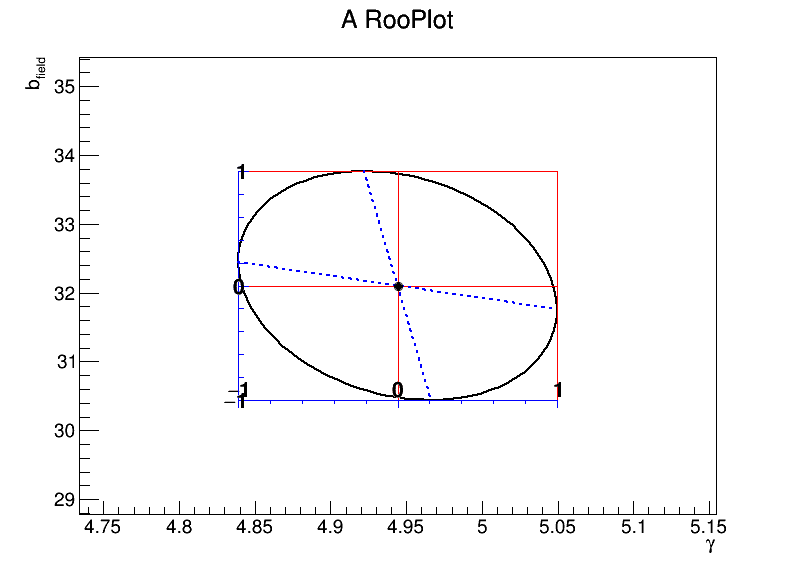

In [17]:
plot_correlation(fit_res_tot, decay_time, osc_amp_field)
c1

So, let's look at this results.  Our original results (for $b$) were:

$$
b = 7.9032 \pm 0.121
$$

and for $b_{\text{field}}$:

$$
b_{\text{field}} = 31.611 \pm 1.64
$$

Note that, we could have simply gotten this number with simple propagation of error (assuming no correlations):

$$
b_{\text{field}} = 4.0 b = 31.6128
$$

and

$$
\sigma_{b_{\text{field}}} = 31.6128 \sqrt{\left(\frac{0.2}{4.0}\right)^2 + \left(\frac{0.121}{7.9032}\right)^2} = 1.65 
$$


In [18]:
import math
b = 7.9032
b_err = 0.121

b_field = muT_per_ADC*b

b_field_err = b_field*math.sqrt((muT_per_ADC_err/muT_per_ADC)**2 + (b_err/b)**2)

print("b_field = {} +- {}".format(b_field, b_field_err))

b_field = 31.6128 +- 1.65308161008


The slight difference in results is neglible (and to be expected, since the function minimization relies upon mapping out the $\chi^2$ function and is therefore subject to some precision issues).  However, this is very convenient because it allows us to directly use our parameter of interest.  This can be especially powerful in more complex situations when applying the calibration or external measurement is not as trivial as the multiplication of a constant.  In particular, this methodology enables the propagation of errors in complex situations where usage of 'normal' error propagation is difficult or impossible.